# Montecarlo Regression for RSL data

This scripts loads Common Era sea level data and calculates residual vertical land movements (VLM), once post-industrial RSL rise and GIA are taken into account. The calculation of VLM is done by randomply sampling (10<sup>4</sup> times) corrected RSL and age within their error bars and fitting a linear regression through the points. Max, min, average and Standard deviation slopes of regression lines (corresponding to VLM) are then calculated and plotted.

This script substitutes the "Orthogonal Distance Regression", used in a previous version of the MS.

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import matplotlib.pyplot as plt

#Import the dataframe
RSL=pd.read_excel('Common_era.xlsx', header=0)
RSL

,Sample Name,Island Name,14 C age,14 C error,Mean age [cal a BP],Error (yr),Elevation [m] with respect to msl,HLC [m],RSL [m],Vertical error ± [m]
0,PS_FMA1,Suranti,490.00,30,114.0,114.0,-1.484000,-0.749464,-0.534536,0.252456
1,PS_FMA2,Suranti,560.00,30,187.5,91.5,-1.224000,-0.749464,-0.144536,0.248464
2,PS_FMA3,Suranti,620.00,30,236.5,96.5,-1.194000,-0.749464,-0.114536,0.248464
3,PT_FMA5,Tambakulu,460.00,30,95.0,95.0,-0.907699,-0.749464,-0.158235,0.130897
4,PT_FMA6,Tambakulu,490.00,30,114.0,114.0,-0.907699,-0.749464,-0.158235,0.130897
5,PT_FMA7,Tambakulu,470.00,30,112.5,112.5,-0.987699,-0.749464,-0.238235,0.130897
6,PT_FMA8,Tambakulu,106.55,0.4 pMC,36.5,11.5,-0.837699,-0.749464,0.111765,0.230725
7,PT_FMA9,Tambakulu,420.00,30,58.0,58.0,-0.967699,-0.749464,-0.088235,0.230725


Hereafter three values must be inserted:
**Time of survey**

**Glacial Isostatic Adjustment land uplift/subsidence rates (m/yr)**

**post-industrial sea level rise (m)**

The script uses these values to calculate paleo RSL and vertical paleo RSL uncertainties corrected for post-industrial sea level rise and GIA.

In [10]:
#Modify the values below as necessary

#Time of Survey
ToS=2017
#Glacial Isostatic Adjustment land uplift/subsidence rates (m/yr)
GIA_avg=0.00038
GIA_sd=0.00009
RSL['GIA_corr']=GIA_avg*(RSL['Mean age [cal a BP]']+(ToS-1950))
RSL['GIA_corr_Sd']=abs(RSL['GIA_corr'])*(np.sqrt(((GIA_sd/GIA_avg)**2)+
                                                ((RSL['Error (yr)']/(RSL['Mean age [cal a BP]']+(ToS-1950)))**2)))
#post-industrial sea level rise (m)
ESL_1900=0.1848
ESL_1900SD=0.0259

#RSL corrections calculations
RSL['Corr_Elev']=RSL['RSL [m]']+ESL_1900-RSL['GIA_corr']
RSL['Corr_Elev_sd']=np.sqrt(RSL['Vertical error ± [m]']**2+ESL_1900SD**2+RSL['GIA_corr_Sd']**2)

print ('Table 1 - Sea level data used')
RSL

Table 1 - Sea level data used


,Sample Name,Island Name,14 C age,14 C error,Mean age [cal a BP],Error (yr),Elevation [m] with respect to msl,HLC [m],RSL [m],Vertical error ± [m],GIA_corr,GIA_corr_Sd,Corr_Elev,Corr_Elev_sd
0,PS_FMA1,Suranti,490.00,30,114.0,114.0,-1.484000,-0.749464,-0.534536,0.252456,0.06878,0.046282,-0.418516,0.257967
1,PS_FMA2,Suranti,560.00,30,187.5,91.5,-1.224000,-0.749464,-0.144536,0.248464,0.09671,0.041636,-0.056446,0.253256
2,PS_FMA3,Suranti,620.00,30,236.5,96.5,-1.194000,-0.749464,-0.114536,0.248464,0.11533,0.045725,-0.045066,0.253960
3,PT_FMA5,Tambakulu,460.00,30,95.0,95.0,-0.907699,-0.749464,-0.158235,0.130897,0.06156,0.038933,-0.034995,0.138999
4,PT_FMA6,Tambakulu,490.00,30,114.0,114.0,-0.907699,-0.749464,-0.158235,0.130897,0.06878,0.046282,-0.042215,0.141234
5,PT_FMA7,Tambakulu,470.00,30,112.5,112.5,-0.987699,-0.749464,-0.238235,0.130897,0.06821,0.045701,-0.121645,0.141044
6,PT_FMA8,Tambakulu,106.55,0.4 pMC,36.5,11.5,-0.837699,-0.749464,0.111765,0.230725,0.03933,0.010289,0.257235,0.232402
7,PT_FMA9,Tambakulu,420.00,30,58.0,58.0,-0.967699,-0.749464,-0.088235,0.230725,0.04750,0.024745,0.049065,0.233489


The code below performs the Montecarlo linear regression.

In [11]:
x=[]
y=[]
rsq=[]
slope=[]

val = np.linspace(0, 10000, num=10001)
for k in val:
    for index, row in RSL.iterrows():
        x.append(np.random.normal(row['Mean age [cal a BP]'], row['Error (yr)']))
        y.append(np.random.normal(row['RSL [m]'], row['Vertical error ± [m]']))
        X=np.asarray(x)
        Y=np.asarray(y)
        X=X.reshape((-1, 1))
    model = LinearRegression(fit_intercept=False).fit(X, Y)
    slope_i=(model.coef_[0])
    slope.append(slope_i)
    x=[]
    y=[]

The code below plots the regression lines

Text(0, 0.5, 'RSL [m]')

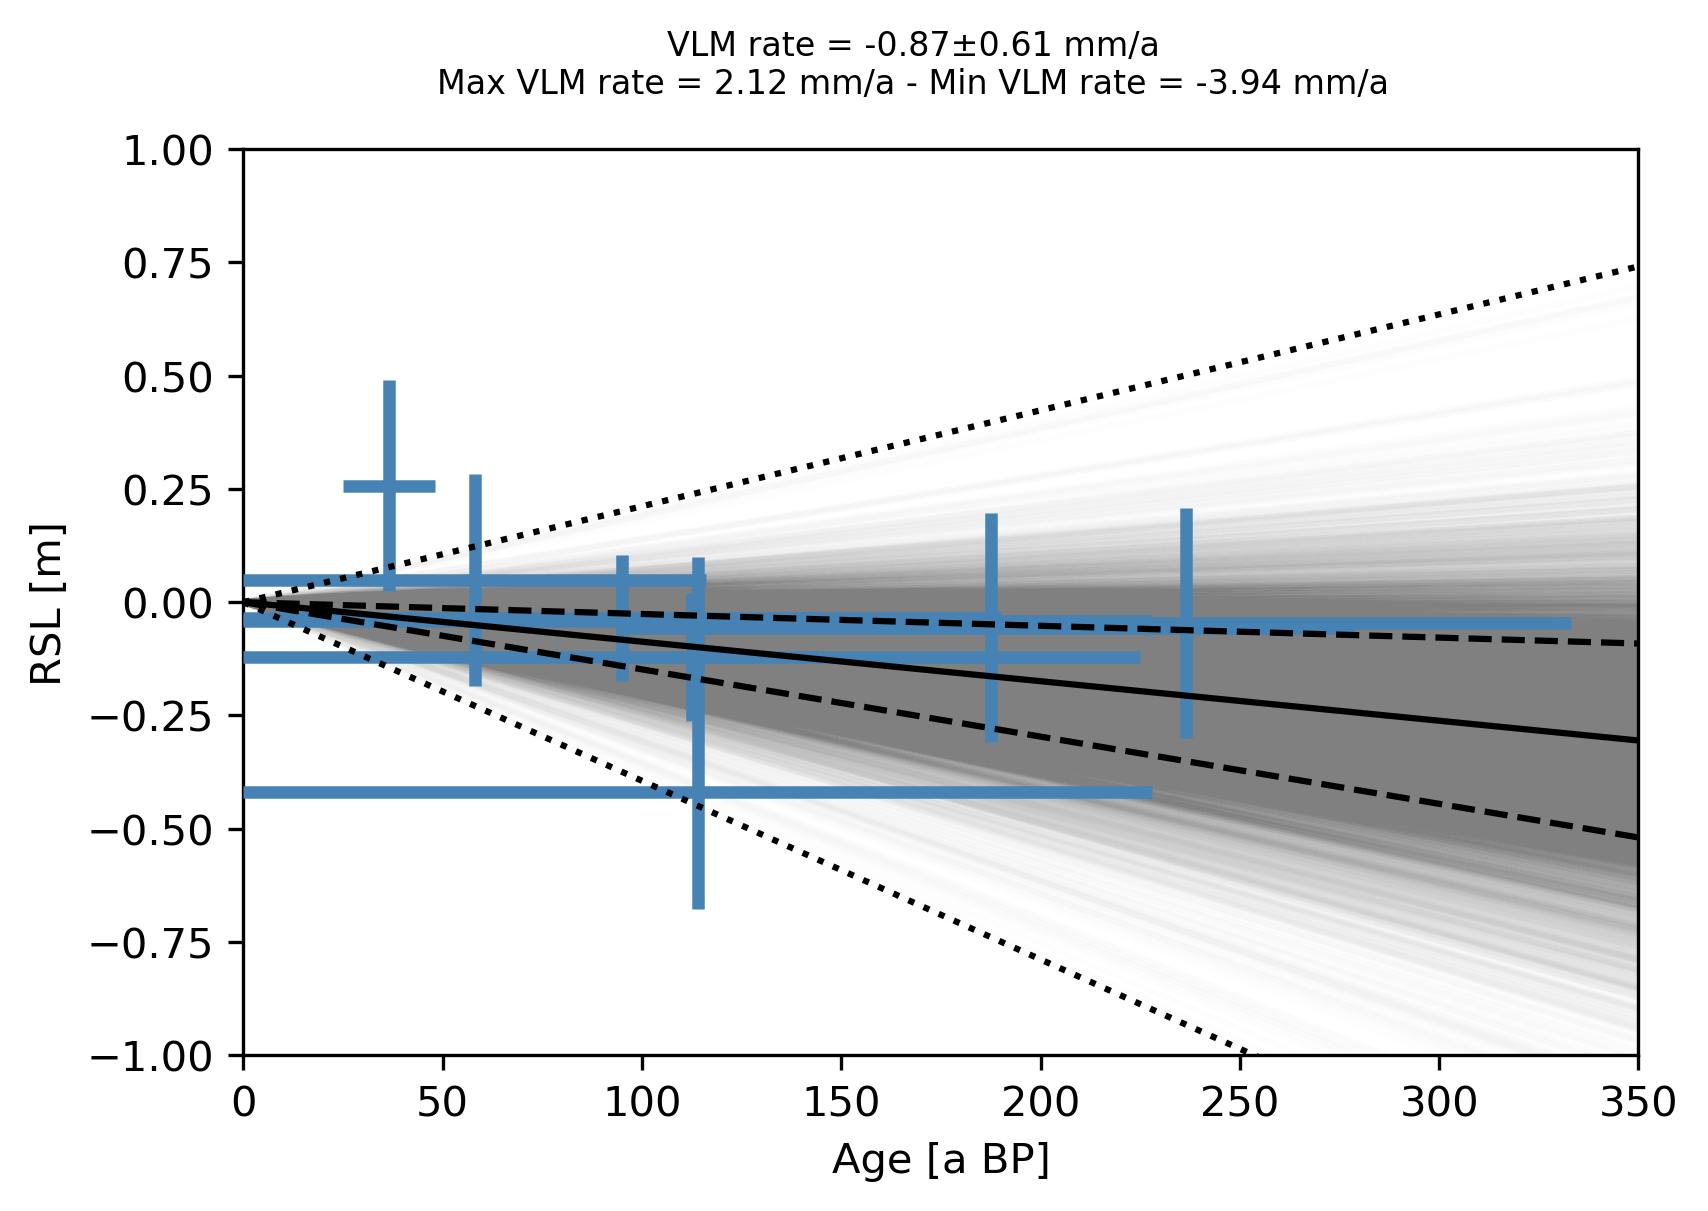

In [12]:
from pylab import *
figure(num=None, dpi=300, facecolor='w', edgecolor='k')
fig = gcf()
fig.suptitle('VLM rate = {0:.2f}±{1:.2f} mm/a \n'
             'Max VLM rate = {2:.2f} mm/a - Min VLM rate = {3:.2f} mm/a \n'
             .format(np.mean(slope)*1000,np.std(slope)*1000,max(slope)*1000,min(slope)*1000), fontsize=8)

#Set X and Y axis limits
axes = plt.gca()
axes.set_xlim([0,350])
axes.set_ylim([-1,1])

#Plots the datapoints corrected for recent sea level rise and GIA
plt.errorbar(RSL['Mean age [cal a BP]'],RSL['Corr_Elev'], yerr=RSL['Corr_Elev_sd'], 
             xerr=RSL['Error (yr)'], linestyle='None', ecolor='steelblue',lw=3,zorder=5)

#Plots all the linear fits calculated at the previous step
def line_gen(slope, intercept):
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='grey', zorder=1,alpha=0.01) 
val=[int(i) for i in val]
for k in val:
 line_gen(slope[k],0)

#Plots maximum and minimum linear fits
def line_minmax(slope, intercept):
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, ':',color='k',zorder=10)
max_Slope=max(slope)
line_minmax(max_Slope,0)
min_Slope=min(slope)
line_minmax(min_Slope,0)

#Plots the average linear fit
def line_avg(slope, intercept):
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals,color='k',zorder=10)
avg_Slope=np.mean(slope)
line_avg(avg_Slope,0)

#Plots upper and lower std ranges of linear fit
def line_std(slope, intercept): 
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals,'--',color='k',zorder=10)
st_Slope=np.std(slope)
line_std(avg_Slope+st_Slope,0)
st_Slope=np.std(slope)
line_std(avg_Slope-st_Slope,0)

plt.xlabel('Age [a BP]')
plt.ylabel('RSL [m]')


#Uncomment the following if you want to save the figure in jpg format.
#plt.savefig("VLMrates.png", dpi=300)

**Main code help from:**<br>
https://realpython.com/linear-regression-in-python/

**Reference**<br>
This script is part of the Supplementary material of Bender et al., Climate of the Past, Under rev.

**Acknowledgments**<br>
This work was supported through grant SEASCHANGE (RO-5245/1-1) from the Deutsche Forschungsgemeinschaft (DFG) as part of the Special Priority Program (SPP)-1889 “Regional Sea Level Change and Society”

**Welcome updates**<br>
There are two possible improvements. The first is to force the normal random sampling not to draw ages that are negative. This would possibly change (albeit maybe not significantly slightly) the results. The second avenue for improvement would be to limit the number of regression lines calculated by applying a thresold on the r-squared resulting from each iteration. *De facto* throwing out less plausible regressions, the results will probably change significantly. 